In [168]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

In [169]:
# Configurable parameters for dynamic use
# Set date_column and quantity_column to None for auto-detection
CONFIG = {
    'file_path': 'datasets\dt3.csv',  # Path to your CSV
    'date_column': None,  # Set to None for auto-detection; otherwise specify name
    'quantity_column': None,  # Set to None for auto-detection; otherwise specify name
    'date_format': '%d/%m/%Y',  # Date format (e.g., DD/MM/YYYY); used if known
    'aggregation_freq': 'D',  # 'D' for daily, 'M' for monthly, 'W' for weekly
    'forecast_periods': 365,  # Number of periods to forecast (e.g., months)
    'plot_title': 'Quantity Forecast with Prophet',
    'plot_xlabel': 'Date',
    'plot_ylabel': 'Quantity (Units Sold)',
    'date_keywords': ['trandate_ddmmyyyy','date', 'time', 'order date', 'ship date', 'timestamp'],
    'quantity_keywords': ['quantity','qty','units','amount','number of items']
}

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Fau\AppData\Local\Temp\ipykernel_33912\2797593044.py:4: SyntaxWarning: invalid escape sequence '\d'
  'file_path': 'datasets\dt3.csv',  # Path to your CSV


In [170]:
def detect_date_column(df, date_format=None):
    """
    Auto-detect the date column by checking names and data types/conversion.
    Returns the column name if found, else None.
    """
    for col in df.columns:
        # Check by name (case-insensitive)
        if any(keyword.lower() in col.lower() for keyword in CONFIG['date_keywords']):
            return col

        # Check by data type or conversion
        try:
            converted = pd.to_datetime(df[col], format=date_format, errors='coerce')
            if converted.notna().mean() > 0.5:  # More than 50% valid dates
                return col
        except:
            pass
    print("No date column detected.")
    return None

In [171]:
def detect_quantity_column(df):
    """
    Auto-detect the quantity column by checking names and data types.
    Looks for numeric columns with names indicating quantity.
    Returns the column name if found, else None.
    """
    for col in df.columns:
        # Check if numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check by name (case-insensitive)
            if any(keyword.lower() in col.lower() for keyword in CONFIG['quantity_keywords']):
                return col
    print("No quantity column detected.")
    return None

In [172]:
def load_data(file_path, date_col=None, quantity_col=None, date_format=None):
    """
    Universal data loader: CSV, XLS, XLSX, JSON, JSONL
    Auto-detects date & quantity columns if None.
    Returns df, detected_date_col, detected_quantity_col
    """
    import os
    import pandas as pd

    # === 1. File existence check ===
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None, None

    file_ext = os.path.splitext(file_path)[1].lower()
    df = None

    # === 2. LOAD BY FILE TYPE ===
    # --- Excel: .xlsx, .xls ---
    if file_ext in ['.xlsx', '.xls']:
        try:
            df = pd.read_excel(file_path, engine=None)
            print(f"Loaded Excel file ({file_ext}): {os.path.basename(file_path)}")
        except Exception as e:
            print(f"Failed to read Excel file: {e}")
            return None, None, None

    # --- CSV / TSV / TXT (text-based) ---
    elif file_ext in ['.csv', '.txt', '.tsv']:
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        for enc in encodings:
            try:
                df = pd.read_csv(file_path, encoding=enc, sep=None, engine='python')
                print(f"Loaded text file with encoding: {enc}")
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                print(f"Failed with {enc}: {e}")
                continue
        else:
            print("Error: Could not read text file with any common encoding.")
            return None, None, None

    # --- JSON: .json, .jsonl, .ndjson ---
    elif file_ext in ['.json', '.jsonl', '.ndjson']:
        try:
            if file_ext == '.json':
                df = pd.read_json(file_path, orient='records', lines=False)
                print("Loaded standard JSON file")
            else:
                df = pd.read_json(file_path, orient='records', lines=True)
                print("Loaded JSONL/NDJSON file")
        except Exception as e:
            print(f"Failed to read JSON file: {e}")
            return None, None, None

    # --- Unsupported ---
    else:
        print(f"Unsupported file type: {file_ext}")
        return None, None, None

    # === 3. POST-LOAD PROCESSING ===
    print(f"Loaded data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # --- Auto-detect date column if not provided ---
    if date_col is None:
        date_col = detect_date_column(df, date_format)
        if date_col is None:
            raise ValueError("Could not auto-detect date column. Please set 'date_column' in CONFIG.")
        print(f"Auto-detected date column: {date_col}")

    # --- Auto-detect quantity column if not provided ---
    if quantity_col is None:
        quantity_col = detect_quantity_column(df)
        if quantity_col is None:
            raise ValueError("Could not auto-detect quantity column. Please set 'quantity_column' in CONFIG.")
        print(f"Auto-detected quantity column: {quantity_col}")

    # --- Clean & convert ---
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df[quantity_col] = pd.to_numeric(df[quantity_col], errors='coerce')

    # Drop rows with invalid date or quantity
    df = df.dropna(subset=[date_col, quantity_col])

    if df.empty:
        print("Error: No valid data after cleaning.")
        return None, None, None

    print(f"Cleaned data shape: {df.shape}")
    return df, date_col, quantity_col

In [173]:

def aggregate_data(df, date_col, quantity_col, freq):
    """
    Aggregate data by date (sum values over specified frequency).
    Returns DataFrame with 'ds' and 'y' columns for Prophet.
    """
    try:
        agg_df = df.groupby(date_col)[quantity_col].sum().reset_index()
        agg_df.columns = ['ds', 'y']
        if freq != 'D':  # If not daily, resample to desired frequency
            agg_df.set_index('ds', inplace=True)
            agg_df = agg_df.resample(freq).sum().reset_index()
            agg_df['y'] = agg_df['y'].fillna(0)  # Fill missing periods
        return agg_df
    except Exception as e:
        print(f"Error aggregating data: {e}")
        return None


In [174]:
def fit_prophet_model(df):
    """
    Fit Prophet model to the data.
    """
    try:
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode='additive'  # or 'multiplicative' based on data
        )
        model.fit(df)
        return model
    except Exception as e:
        print(f"Error fitting model: {e}")
        return None

In [175]:
def make_forecast(model, periods, freq):
    """
    Generate future forecast for specified periods.
    """
    try:
        future = model.make_future_dataframe(periods=periods, freq=freq)
        forecast = model.predict(future)
        return forecast
    except Exception as e:
        print(f"Error making forecast: {e}")
        return None

In [176]:
def plot_forecast(model, forecast, df, title, xlabel, ylabel):
    """
    Plot historical data, forecast, and components.
    Returns the forecast figure so we can annotate it later.
    """
    try:
        # ---- 1. Forecast plot (this is the one we want to annotate) ----
        forecast_fig = model.plot(forecast)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        # ---- 2. Component plot (optional – we don’t need it for the total) ----
        model.plot_components(forecast)
        plt.show()                # shows components immediately

        return forecast_fig      # <-- return the forecast figure

    except Exception as e:
        print(f"Error plotting: {e}")
        return None

In [177]:
def main(config):
    """
    Main function to run the forecasting pipeline.
    """
    # Load and preprocess (with auto-detection if needed)
    df, date_col, quantity_col = load_data(
        config['file_path'],
        config['date_column'],
        config['quantity_column'],
        config['date_format']
    )
    if df is None:
        return

    # Aggregate data
    agg_df = aggregate_data(
        df,
        date_col,
        quantity_col,
        config['aggregation_freq']
    )
    if agg_df is None:
        return

    # Fit model
    model = fit_prophet_model(agg_df)
    if model is None:
        return

    # Forecast
    forecast = make_forecast(model, config['forecast_periods'], config['aggregation_freq'])
    if forecast is None:
        return

    # ---- Plot & capture the forecast figure ----
    forecast_fig = plot_forecast(
        model,
        forecast,
        agg_df,
        config['plot_title'],
        config['plot_xlabel'],
        config['plot_ylabel']
    )
    if forecast_fig is None:
        return

        # -------------------------------------------------------------
    # NEW: Predict TOTAL UNITS SOLD for the entire future period
    # -------------------------------------------------------------
    historical_dates = set(agg_df['ds'])
    future_forecast = forecast[~forecast['ds'].isin(historical_dates)].copy()

    # ---- Sum the point estimate (yhat) ----
    total_forecasted_units = future_forecast['yhat'].sum()

    # ---- Optional: 80 % prediction interval ----
    total_lower = future_forecast['yhat_lower'].sum()
    total_upper = future_forecast['yhat_upper'].sum()

    # ---- Pretty-print the result ----
    print("\n" + "="*60)
    print("TOTAL UNITS SOLD FORECAST FOR THE NEXT PERIOD")
    print("="*60)
    print(f"Forecast horizon : {config['forecast_periods']} {config['aggregation_freq']} periods")
    print(f"Total forecasted units sold : {total_forecasted_units:,.0f}")
    print(f"80% prediction interval      : [{total_lower:,.0f} – {total_upper:,.0f}] units")
    print("="*60 + "\n")

    # -------------------------------------------------------------
    # Annotate the forecast figure with the total units
    # -------------------------------------------------------------
    ax = forecast_fig.axes[0]                     # main axis
    last_historical_date = agg_df['ds'].max()
    future_end_date = forecast['ds'].max()

    # Horizontal dashed line for the cumulative total
    ax.axhline(y=total_forecasted_units, color='green', linestyle='--', linewidth=1.5, label=f'Total Units: {total_forecasted_units:,.0f}')

    # Text label on the right side
    ax.text(future_end_date, total_forecasted_units,
            f' {total_forecasted_units:,.0f}',
            va='center', ha='left', backgroundcolor='w',
            fontsize=10, fontweight='bold', color='green')

    ax.legend(loc='upper left')
    plt.show()

02:15:56 - cmdstanpy - INFO - Chain [1] start processing


Loaded text file with encoding: utf-8
Loaded data shape: (13587, 12)
Columns: ['BranchID', 'BranchName', 'DeptID', 'DeptName', 'CategoryID', 'CategoryName', 'Qty', 'NetSales', 'Cost', 'GM$', 'GM%', 'TranDate_DDMMYYYY']
Auto-detected date column: TranDate_DDMMYYYY
Auto-detected quantity column: Qty
Cleaned data shape: (13587, 12)


02:15:56 - cmdstanpy - INFO - Chain [1] done processing


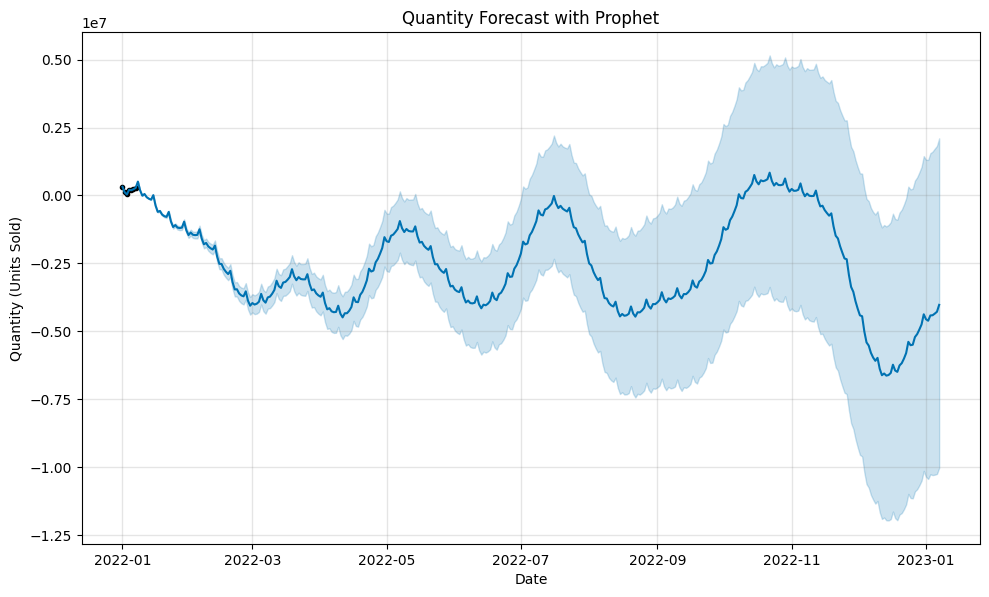

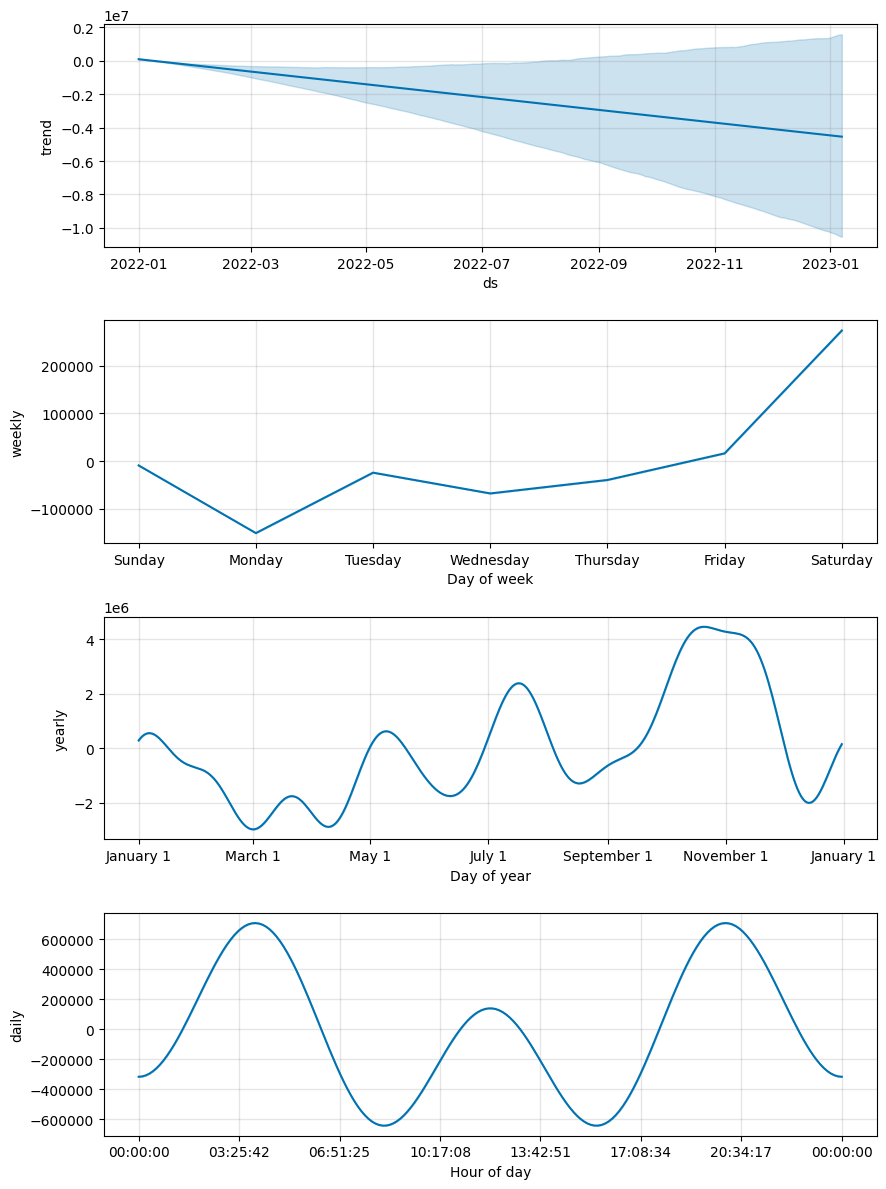


TOTAL UNITS SOLD FORECAST FOR THE NEXT PERIOD
Forecast horizon : 365 D periods
Total forecasted units sold : -943,091,334
80% prediction interval      : [-1,825,368,769 – -56,995,055] units



In [178]:
if __name__ == "__main__":
      main(CONFIG)